In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy

# -------------------------------
# GridWorld with explicit P table
# -------------------------------
class GridWorld:
    def __init__(self, nrows=4, ncols=4, terminals=None, obstacles=None,
                 default_reward=-1.0, terminal_rewards=None, slip_prob=0.0):
        """
        nrows, ncols: grid shape
        terminals: list of state indices (0..nS-1)
        obstacles: list of state indices (treated as non-traversable; agent stays)
        default_reward: reward for non-terminal transitions
        terminal_rewards: dict {s: reward}
        slip_prob: probability of taking a perpendicular action
                   if 0 => deterministic
        """
        self.nrows = nrows
        self.ncols = ncols
        self.nS = nrows * ncols
        self.nA = 4  # up,right,down,left
        self.terminals = set(terminals or [])
        self.obstacles = set(obstacles or [])
        self.default_reward = default_reward
        self.terminal_rewards = terminal_rewards or {}
        self.slip_prob = slip_prob
        self.P = self._build_transitions()

    def _rc(self, s):
        return divmod(s, self.ncols)

    def _s(self, r, c):
        return r * self.ncols + c

    def _build_transitions(self):
        P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        deltas = [(-1,0),(0,1),(1,0),(0,-1)]

        for s in range(self.nS):
            if s in self.terminals:
                for a in range(self.nA):
                    r = self.terminal_rewards.get(s, 0.0)
                    P[s][a] = [(1.0, s, r, True)]
                continue
            if s in self.obstacles:
                for a in range(self.nA):
                    P[s][a] = [(1.0, s, self.default_reward, False)]
                continue

            row, col = self._rc(s)
            for a in range(self.nA):
                outcomes = {}
                if self.slip_prob == 0:
                    probs = [(a, 1.0)]
                else:
                    perp = [(a-1)%4, (a+1)%4]
                    probs = [(a, 1 - self.slip_prob), (perp[0], self.slip_prob/2), (perp[1], self.slip_prob/2)]
                for act, prob in probs:
                    dr, dc = deltas[act]
                    nr = max(0, min(self.nrows-1, row + dr))
                    nc = max(0, min(self.ncols-1, col + dc))
                    ns = self._s(nr, nc)
                    # obstacle or boundary handled by limiting nr,nc above; if obstacle, agent stays
                    if ns in self.obstacles:
                        ns = s
                    done = ns in self.terminals
                    reward = self.terminal_rewards.get(ns, self.default_reward)
                    key = (ns, reward, done)
                    outcomes[key] = outcomes.get(key, 0.0) + prob
                P[s][a] = [(p, ns, r, d) for (ns, r, d), p in outcomes.items()]
        return P

    def render_ascii(self):
        grid = []
        for r in range(self.nrows):
            row = []
            for c in range(self.ncols):
                s = self._s(r,c)
                if s in self.terminals:
                    row.append('T')
                elif s in self.obstacles:
                    row.append('#')
                else:
                    row.append('.')
            grid.append(' '.join(row))
        print(''.join(grid))


In [2]:
# -------------------------------
# Policy Evaluation
# -------------------------------
def policy_evaluation(P, policy, nS, nA, gamma=0.9, theta=1e-6, synchronous=True):
    """
    P: transition model (dict)
    policy: shape (nS, nA) probability distribution
    Returns: V, history (list of V snapshots), deltas(list)
    """
    V = np.zeros(nS)
    history = [V.copy()]
    deltas = []
    while True:
        delta = 0.0
        if synchronous:
            V_new = V.copy()
            for s in range(nS):
                if all([item[0] == 1.0 and item[1] == s and item[3] for a in range(nA) for item in P[s][a]]):
                    # terminal check: simplified
                    V_new[s] = 0.0
                    continue
                v = 0.0
                for a in range(nA):
                    for prob, ns, rew, done in P[s][a]:
                        next_val = 0.0 if done else V[ns]
                        v += policy[s, a] * prob * (rew + gamma * next_val)
                V_new[s] = v
                delta = max(delta, abs(V_new[s] - V[s]))
            V = V_new
        else:
            for s in range(nS):
                v_old = V[s]
                v = 0.0
                for a in range(nA):
                    for prob, ns, rew, done in P[s][a]:
                        next_val = 0.0 if done else V[ns]
                        v += policy[s, a] * prob * (rew + gamma * next_val)
                V[s] = v
                delta = max(delta, abs(v_old - V[s]))
        history.append(V.copy())
        deltas.append(delta)
        if delta < theta:
            break
    return V, history, deltas


In [3]:
# -------------------------------
# Policy Improvement
# -------------------------------
def policy_improvement(P, V, nS, nA, gamma=0.9):
    policy = np.zeros((nS, nA))
    for s in range(nS):
        q = np.zeros(nA)
        for a in range(nA):
            for prob, ns, rew, done in P[s][a]:
                next_val = 0.0 if done else V[ns]
                q[a] += prob * (rew + gamma * next_val)
        best = np.argmax(q)
        policy[s, best] = 1.0
    return policy


In [ ]:
# Policy Iteration
def policy_iteration(P, nS, nA, gamma=0.9, theta=1e-6, eval_synchronous=True, max_iter=100):
    # start with uniform random policy
    policy = np.ones((nS, nA)) / nA
    policy_history = [policy.copy()]
    V_history = []
    deltas_history = []
    times = []

    t0 = time.perf_counter()
    for it in range(max_iter):
        it_start = time.perf_counter()
        V, histV, deltas = policy_evaluation(P, policy, nS, nA, gamma=gamma, theta=theta, synchronous=eval_synchronous)
        V_history.extend(histV)
        deltas_history.append(deltas[-1])
        new_policy = policy_improvement(P, V, nS, nA, gamma=gamma)
        policy_history.append(new_policy.copy())
        times.append(time.perf_counter() - it_start)
        if np.array_equal(new_policy, policy):
            total_time = time.perf_counter() - t0
            return new_policy, V, policy_history, V_history, deltas_history, times, it+1, total_time
        policy = new_policy
    total_time = time.perf_counter() - t0
    return policy, V, policy_history, V_history, deltas_history, times, max_iter, total_time


In [ ]:
# Value Iteration 
def value_iteration(P, nS, nA, gamma=0.9, theta=1e-6, synchronous=True, max_iter=1000):
    V = np.zeros(nS)
    V_history = [V.copy()]
    deltas = []
    times = []
    t0 = time.perf_counter()
    for it in range(max_iter):
        it_start = time.perf_counter()
        delta = 0.0
        if synchronous:
            V_new = V.copy()
            for s in range(nS):
                q = np.zeros(nA)
                for a in range(nA):
                    for prob, ns, rew, done in P[s][a]:
                        next_val = 0.0 if done else V[ns]
                        q[a] += prob * (rew + gamma * next_val)
                V_new[s] = np.max(q)
                delta = max(delta, abs(V_new[s] - V[s]))
            V = V_new
        else:
            for s in range(nS):
                v_old = V[s]
                q = np.zeros(nA)
                for a in range(nA):
                    for prob, ns, rew, done in P[s][a]:
                        next_val = 0.0 if done else V[ns]
                        q[a] += prob * (rew + gamma * next_val)
                V[s] = np.max(q)
                delta = max(delta, abs(V[s] - v_old))
        V_history.append(V.copy())
        deltas.append(delta)
        times.append(time.perf_counter() - it_start)
        if delta < theta:
            break
    # extract greedy policy
    policy = np.zeros((nS, nA))
    for s in range(nS):
        q = np.zeros(nA)
        for a in range(nA):
            for prob, ns, rew, done in P[s][a]:
                next_val = 0.0 if done else V[ns]
                q[a] += prob * (rew + gamma * next_val)
        policy[s, np.argmax(q)] = 1.0
    total_time = time.perf_counter() - t0
    return policy, V, V_history, deltas, times, it+1, total_time


In [ ]:
# Visualization helpers
import math

def plot_value_sequence(V_history, nrows, ncols, title_prefix='V iter'):
    n = len(V_history)
    cols = min(6, n)
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()
    for i, V in enumerate(V_history):
        axes[i].imshow(np.array(V).reshape((nrows, ncols)), origin='upper', cmap='coolwarm')
        axes[i].set_title(f'{title_prefix} {i}')
        for (x, y), val in np.ndenumerate(np.array(V).reshape((nrows, ncols))):
            axes[i].text(y, x, f'{val:.2f}', ha='center', va='center', fontsize=8)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
def plot_policy_sequence(policy_history, nrows, ncols, title_prefix='policy'):
    n = len(policy_history)
    cols = min(6, n)
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()
    action_vec = {0:(0,-1), 1:(1,0), 2:(0,1), 3:(-1,0)}  # mapping for plotting
    for i, pol in enumerate(policy_history):
        mat = np.zeros((nrows, ncols, 2))
        for s in range(nrows*ncols):
            r = s // ncols
            c = s % ncols
            a = np.argmax(pol[s])
            dx, dy = action_vec[a]
            mat[r,c,0] = dx
            mat[r,c,1] = dy
        X, Y = np.meshgrid(np.arange(ncols), np.arange(nrows))
        U = mat[:,:,0]
        V = -mat[:,:,1]
        axes[i].quiver(X, Y, U, V)
        axes[i].invert_yaxis()
        axes[i].set_title(f'{title_prefix} {i}')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


In [9]:
def plot_convergence(deltas_list, labels, title='Convergence (delta per iteration)'):
    plt.figure(figsize=(6,4))
    for deltas, lab in zip(deltas_list, labels):
        plt.plot(deltas, label=lab)
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Max |delta|')
    plt.title(title)
    plt.grid(True)
    plt.show()


def plot_times(times_list, labels, title='Wall-clock times per outer-iteration'):
    plt.figure(figsize=(6,4))
    for times, lab in zip(times_list, labels):
        plt.plot(times, label=lab)
    plt.legend()
    plt.xlabel('Outer Iteration')
    plt.ylabel('Seconds')
    plt.title(title)
    plt.grid(True)
    plt.show()


Deterministic GridWorld:
T . . .. . . .. . . .. . . T
Policy Iteration (det): iters=3, time=0.0085s
Value Iteration  (det): iters=4, time=0.0005s


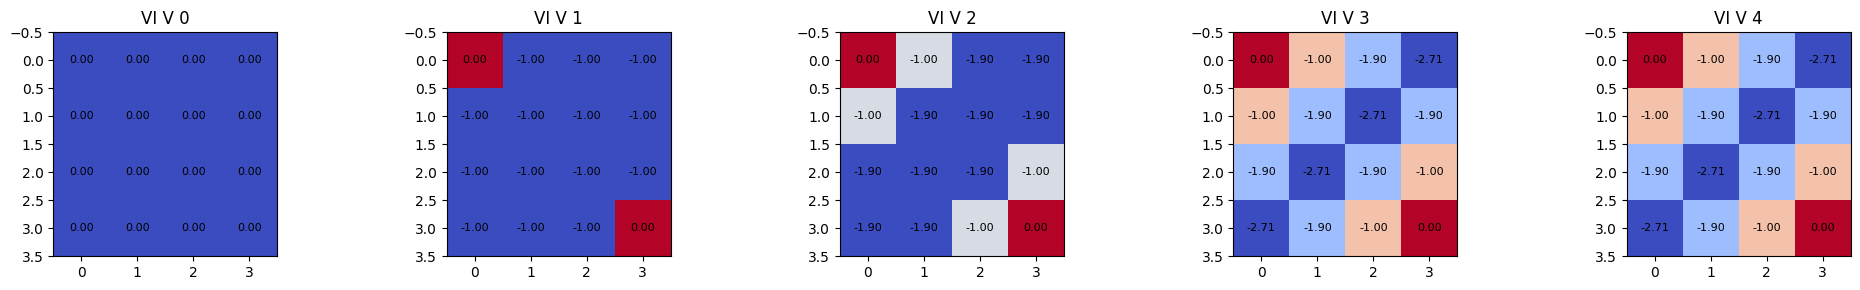

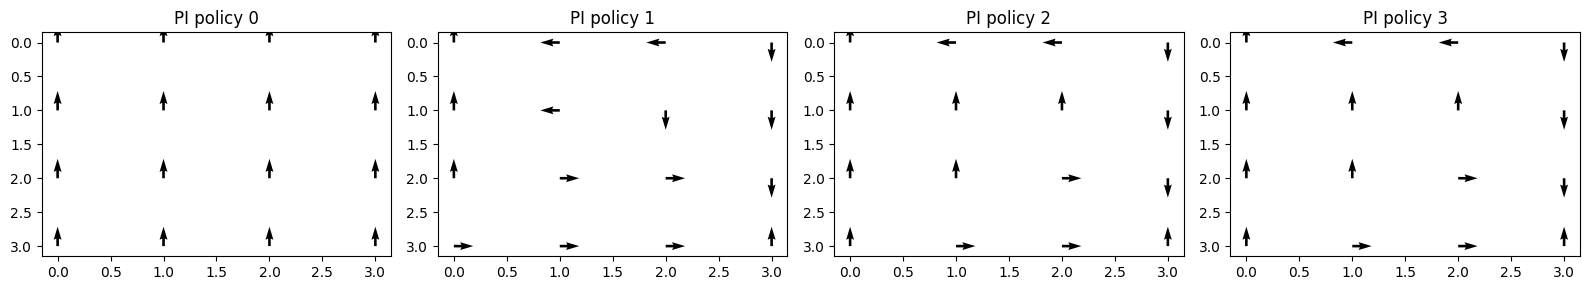

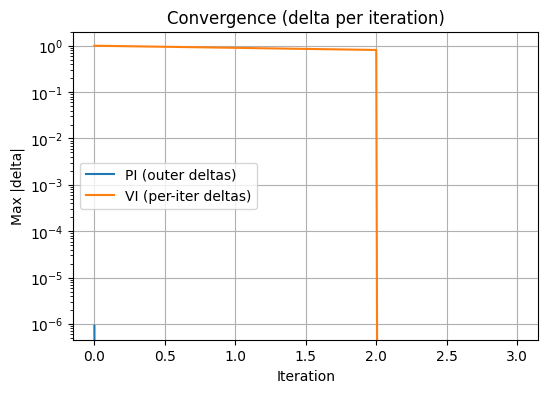

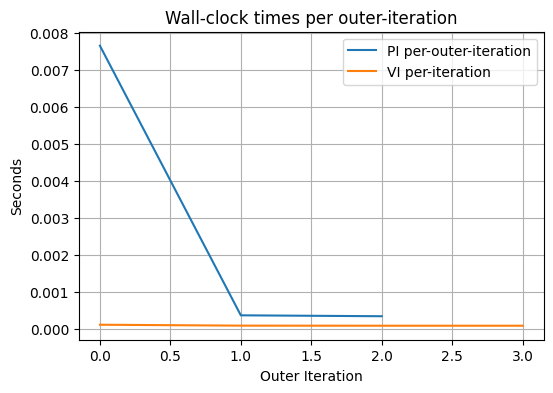

Stochastic GridWorld (slip_prob=0.2):
T . . .. . . .. . . .. . . T
Policy Iteration (sto): iters=3, time=0.0173s
Value Iteration  (sto): iters=19, time=0.0038s


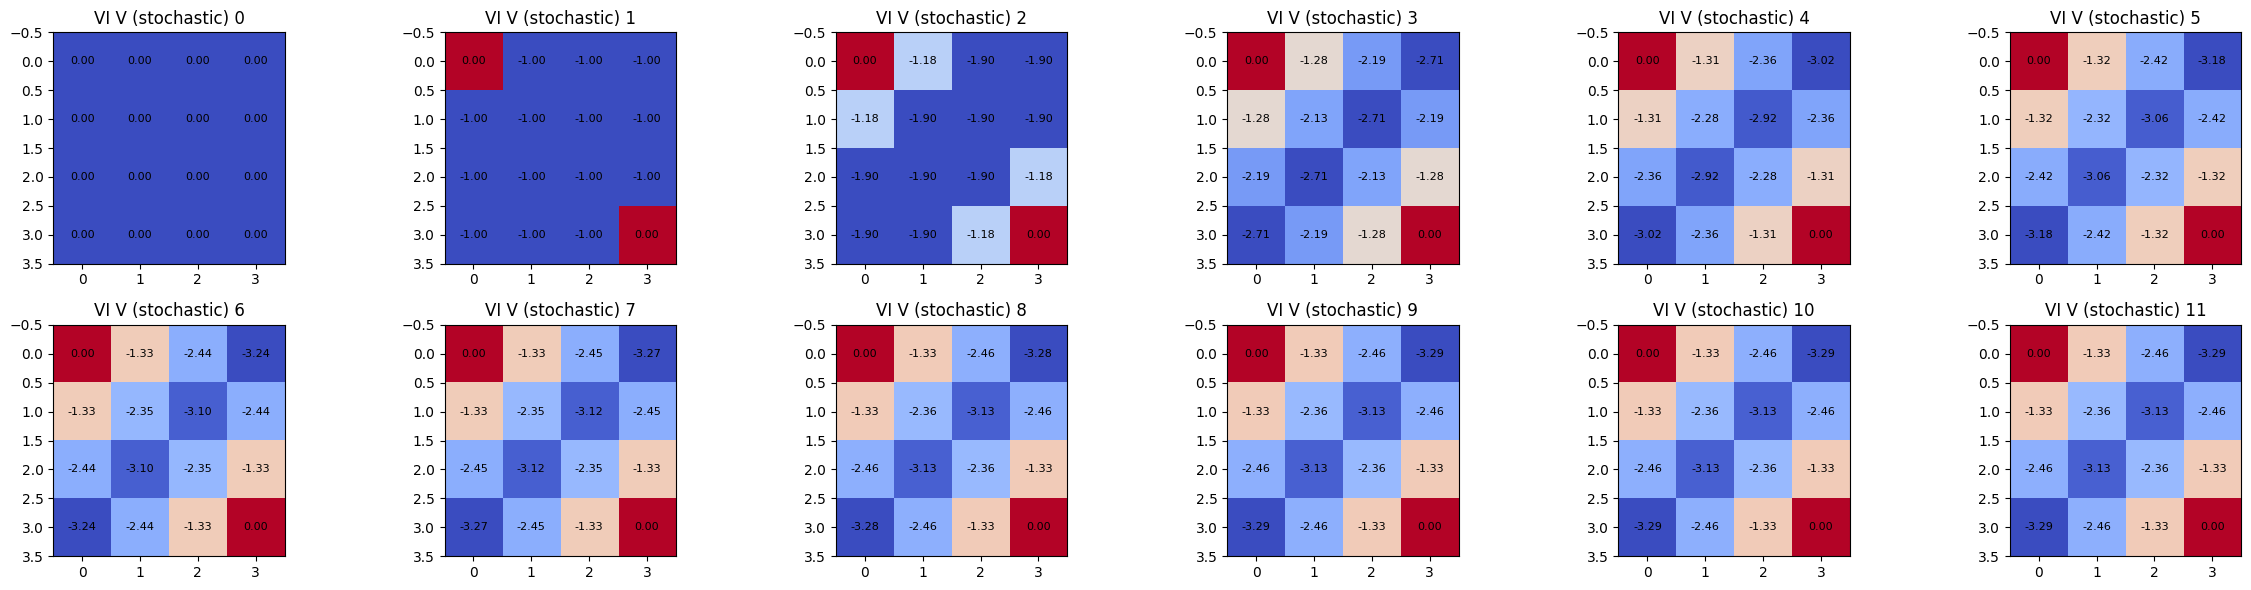

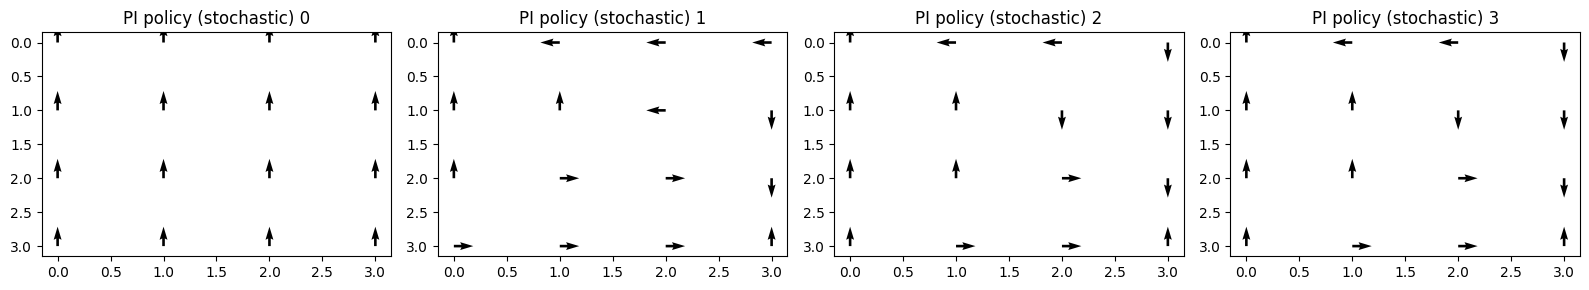

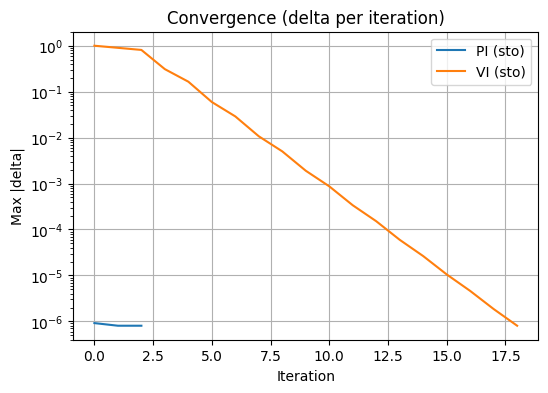

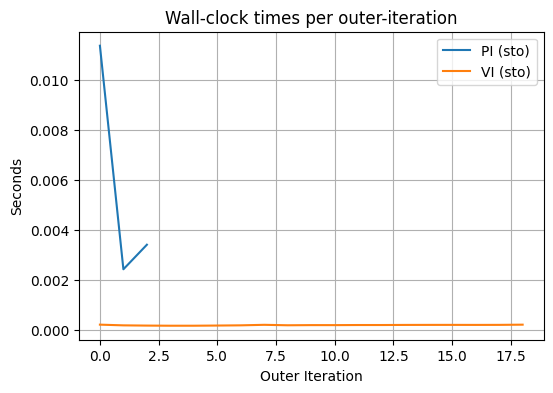

Gymnasium detected: FrozenLake adapter ready.


In [12]:
# -------------------------------
# Experiments: deterministic and stochastic
# -------------------------------
# Deterministic GridWorld (4x4)
gw_det = GridWorld(nrows=4, ncols=4, terminals=[0,15], default_reward=-1.0, slip_prob=0.0)
print('Deterministic GridWorld:')
gw_det.render_ascii()

pol_pi_det, V_pi_det, policy_hist_pi_det, V_hist_pi_det, deltas_pi_det, times_pi_det, iters_pi_det, total_time_pi_det = policy_iteration(gw_det.P, gw_det.nS, gw_det.nA, gamma=0.9, theta=1e-6, eval_synchronous=True)
pol_vi_det, V_vi_det, V_hist_vi_det, deltas_vi_det, times_vi_det, iters_vi_det, total_time_vi_det = value_iteration(gw_det.P, gw_det.nS, gw_det.nA, gamma=0.9, theta=1e-6, synchronous=True)

print(f'Policy Iteration (det): iters={iters_pi_det}, time={total_time_pi_det:.4f}s')
print(f'Value Iteration  (det): iters={iters_vi_det}, time={total_time_vi_det:.4f}s')

# visualize sequences (trim to first 12 snapshots to keep plots readable)
plot_value_sequence(V_hist_vi_det[:12], gw_det.nrows, gw_det.ncols, title_prefix='VI V')
plot_policy_sequence(policy_hist_pi_det[:12], gw_det.nrows, gw_det.ncols, title_prefix='PI policy')
plot_convergence([deltas_pi_det, deltas_vi_det], ['PI (outer deltas)', 'VI (per-iter deltas)'])
plot_times([times_pi_det, times_vi_det], ['PI per-outer-iteration', 'VI per-iteration'])

# -------------------------------
# Stochastic GridWorld (80% intended, 10% left/right)
# -------------------------------
gw_sto = GridWorld(nrows=4, ncols=4, terminals=[0,15], default_reward=-1.0, slip_prob=0.2)
print('Stochastic GridWorld (slip_prob=0.2):')
gw_sto.render_ascii()

pol_pi_sto, V_pi_sto, policy_hist_pi_sto, V_hist_pi_sto, deltas_pi_sto, times_pi_sto, iters_pi_sto, total_time_pi_sto = policy_iteration(gw_sto.P, gw_sto.nS, gw_sto.nA, gamma=0.9, theta=1e-6, eval_synchronous=True)
pol_vi_sto, V_vi_sto, V_hist_vi_sto, deltas_vi_sto, times_vi_sto, iters_vi_sto, total_time_vi_sto = value_iteration(gw_sto.P, gw_sto.nS, gw_sto.nA, gamma=0.9, theta=1e-6, synchronous=True)

print(f'Policy Iteration (sto): iters={iters_pi_sto}, time={total_time_pi_sto:.4f}s')
print(f'Value Iteration  (sto): iters={iters_vi_sto}, time={total_time_vi_sto:.4f}s')

# Visualize last few snapshots
plot_value_sequence(V_hist_vi_sto[:12], gw_sto.nrows, gw_sto.ncols, title_prefix='VI V (stochastic)')
plot_policy_sequence(policy_hist_pi_sto[:12], gw_sto.nrows, gw_sto.ncols, title_prefix='PI policy (stochastic)')
plot_convergence([deltas_pi_sto, deltas_vi_sto], ['PI (sto)', 'VI (sto)'])
plot_times([times_pi_sto, times_vi_sto], ['PI (sto)', 'VI (sto)'])

# -------------------------------
# FrozenLake-v1 adapter (requires gymnasium)
# -------------------------------
try:
    import gymnasium as gym
    def run_on_frozenlake(env_name='FrozenLake-v1', is_slippery=True, map_name='4x4', gamma=0.9, theta=1e-6):
        env = gym.make(env_name, is_slippery=is_slippery, map_name=map_name)
        P = env.unwrapped.P
        nS = env.observation_space.n
        nA = env.action_space.n
        # terminals set
        terminals = set()
        for s in range(nS):
            for a in P[s]:
                for prob, ns, rew, done in P[s][a]:
                    if done:
                        terminals.add(ns)
        # Run VI and PI using P
        pol_vi, V_vi, Vhist_vi, deltas_vi, times_vi, its_vi, t_vi = value_iteration(P, nS, nA, gamma=gamma, theta=theta, synchronous=True)
        pol_pi, V_pi, p_hist_pi, V_hist_pi, deltas_pi, times_pi, its_pi, t_pi = policy_iteration(P, nS, nA, gamma=gamma, theta=theta, eval_synchronous=True)
        return dict(value_iteration=(pol_vi, V_vi, its_vi, t_vi), policy_iteration=(pol_pi, V_pi, its_pi, t_pi))
    print('Gymnasium detected: FrozenLake adapter ready.')
except Exception:
    print('Gymnasium not available; FrozenLake experiments skipped.')
